In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import os
import time
from pathlib import Path
import json
import pickle

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import statsmodels.formula.api as smf

from src.methods.supervised_1d import SupervisedModel_1D
from src.models.CLOCS_1D import cnn_network_contrastive
from src.models.ResNet1D import ResNet1D

from src.utils.metrics import accuracy_at_k, weighted_mean, AUROC
from src.utils.ECG_data_loading import *

from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from lime_timeseries import LimeTimeSeriesExplainer

%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\envs\jpy3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\ProgramData\Anaconda3\envs\jpy3.10\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: rso is an invalid version and will not be supported in a future release
  warnings.warn(
C:\ProgramData\Anaconda3\envs\jpy3.10\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
C:\ProgramData\Anaconda3\envs\jpy3.10\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
C:\ProgramData\Anaconda3\envs\jpy3.10\lib\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:34: Under

# Load functions

In [2]:
torch.cuda.empty_cache()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count(), device)

1 cuda:0


In [3]:
softmax = torch.nn.Softmax(dim=1)
def Get_dataset_id_dict(dataset):
    dataset.return_id_vec = True
    dataset_id_dict = {}
    for i, (x, id_vec, y) in enumerate(dataset):
        ECG_signal = x.ravel()
        ECG_signal_str = "_".join([f"{ele:.3f}" for ele in ECG_signal])
        id_dict = dict(zip(dataset.short_identifier_list, id_vec))
        id_dict["label"] = y
        dataset_id_dict[ECG_signal_str] = id_dict

    return dataset_id_dict


def Lookup_ECG(ECG_signal, dataset_id_dict):
    ECG_signal = ECG_signal.ravel()
    ECG_signal_str = "_".join([f"{ele:.3f}" for ele in ECG_signal])
    id_dict = dataset_id_dict.get(ECG_signal_str)
    return id_dict


def Get_roc_curve_df_from_model_and_data_loader(model, data_loader, target_fpr=0.1, target_threshold=None, use_gpu=False, abstain=False):
    y_true_all_list = []
    scores_all_list = []
    abstention_all_list = []

    device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
    model = model.to(device)
#     model.backbone = model.backbone.to(device)
#     model.classifier = model.classifier.to(device)
    model.eval()
    auroc = AUROC(pos_label=1)

    for i, data in enumerate(data_loader):
        #         print(f"Batch {i} / {len(data_loader)}")
        X, _, y = data
        X, y = X.to(device), y.to(device)
        X_embedding = model.backbone(X).to(device)
        X_logits = model.classifier(X_embedding).to(device)
        y_true_all_list.append(y)

        scores = softmax(X_logits)[:, 1].detach().cpu()
        if abstain:
            abstention_all_list.append(softmax(X_logits)[:, 2].detach().cpu())
        scores_all_list.append(scores)
        auroc.update(scores, y.detach().cpu())

    auroc_value = auroc.compute()
    auroc.reset()
    print(f"auroc_value = {auroc_value:.4f}")
    y_true_all = torch.cat(y_true_all_list, dim=0)
    scores_all = torch.cat(scores_all_list, dim=0)
    if abstain:
        abstention_all = torch.cat(abstention_all_list, dim=0)
    y_true_all_np = y_true_all.detach().cpu().numpy()
    y_scores = scores_all
    y_true = y_true_all_np

    auroc = auroc_value
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    roc_curve_df = pd.DataFrame([fpr, tpr, thresholds]).T
    roc_curve_df.columns = ["fpr", "tpr", "thresholds"]
    if target_threshold is not None:
        closest_threshold_idx = np.argsort(np.abs(roc_curve_df["thresholds"] - target_threshold))[0]
    else:
        closest_threshold_idx = np.argsort(np.abs(roc_curve_df["fpr"] - target_fpr))[0]
    selected_threshold = roc_curve_df["thresholds"][closest_threshold_idx]
    selected_fpr = roc_curve_df["fpr"][closest_threshold_idx]
    roc_curve_results_dict = {"roc_curve_df": roc_curve_df, "selected_threshold": selected_threshold, "selected_fpr": selected_fpr, "auroc": auroc, "y_scores": y_scores, "y_true": y_true, "abstention_all": abstention_all}
    return roc_curve_results_dict


def Get_wrong_predictions_indices_from_roc_curve_results_dict(roc_curve_results_dict, target_threshold=None):
    if target_threshold is None:
        target_threshold = roc_curve_results_dict["selected_threshold"]

    y_true = roc_curve_results_dict["y_true"]
    if hasattr(roc_curve_results_dict["y_scores"], "numpy"):
        y_scores = roc_curve_results_dict["y_scores"].numpy()
    else:
        y_scores = roc_curve_results_dict["y_scores"]
    y_pred = (y_scores > target_threshold).astype(int)
    wrong_indices_dict = {0: np.where(~y_true & y_pred)[0].tolist(), 1: np.where(y_true & ~y_pred)[0].tolist()}
    return wrong_indices_dict


def Filter_data_by_id_dict(ecg_df, id_dict, num_cycle_to_show_each_side=4):
    cycle_ID = ecg_df[
        (ecg_df["patient_ID"] == id_dict["patient_ID"]) \
        & (ecg_df["interval_ID"] == id_dict["interval_ID"]) \
        & (ecg_df["block_ID"] == id_dict["block_ID"]) \
        & (ecg_df["channel_ID"] == id_dict["channel_ID"])
        & (ecg_df["r_ID_abs"] == id_dict["r_ID_abs"])
        ]["cycle_ID"].values[0]
    ecg_df_selected = ecg_df[
        (ecg_df["patient_ID"] == id_dict["patient_ID"]) \
        & (ecg_df["interval_ID"] == id_dict["interval_ID"]) \
        & (ecg_df["block_ID"] == id_dict["block_ID"]) \
        & (ecg_df["channel_ID"] == id_dict["channel_ID"]) \
        & ((ecg_df["cycle_ID"] <= cycle_ID + num_cycle_to_show_each_side) \
           & (ecg_df["cycle_ID"] >= cycle_ID - num_cycle_to_show_each_side))
        ].sort_values(by=["cycle_ID"], ascending=True)
    return ecg_df_selected, cycle_ID


def Show_LIME_explanation_for_idx_with_id(idx_list, dataset, NN_predict_proba, dataset_id_dict, dataset_df,
                                          class_names=None, num_slices=30, num_cycle_to_show_each_side=4,
                                          num_features=10, target_threshold=0.5,
                                          replacement_method="total_mean", entropy_list=None, text_to_show=None, uncertainty_name=None, uncertainty_value_list=None):
    if class_names is None:
        class_names = ['Sinus', 'JET']

    nrow = len(idx_list)
    ncol = 2 * num_cycle_to_show_each_side + 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol, 4 * nrow))
    for i, idx in enumerate(idx_list):
        ecg_signal, _, label = dataset[idx]
        id_dict = Lookup_ECG(ecg_signal, dataset_id_dict)
        ecg_df_selected, cycle_ID = Filter_data_by_id_dict(dataset_df, id_dict,
                                                           num_cycle_to_show_each_side=num_cycle_to_show_each_side)
        #         print(ecg_df_selected)
        #         assert len(ecg_df_selected) == ncol
        for j in range(len(ecg_df_selected)):
            if nrow == 1:
                ax = axes[j]
            elif ncol == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]

            cycle_ID_j = ecg_df_selected["cycle_ID"].values[j]
            patient_ID = ecg_df_selected["patient_ID"].values[j]
            ecg_signal = Normalize(ecg_df_selected[dataset.ecg_colnames].values[j, :])

            uncertainty_value = uncertainty_value_list[idx] if uncertainty_value_list is not None else -1
            uncertainty_text = f"{uncertainty_name}" if uncertainty_value_list is not None else ""
            uncertainty_text_short = f"{uncertainty_value:.3f}" if uncertainty_value_list is not None else ""
            if j == len(ecg_df_selected) // 2:
                entropy_text = f", Ent = {entropy_list[i]:.3f}" if entropy_list is not None else ""
                text_to_show_text = f", {text_to_show}" if text_to_show is not None else ""
                ax.set_title(f"Patient ID: {patient_ID}{text_to_show_text}{entropy_text}{uncertainty_text_short}")
            elif j == 0:
                ax.set_title(f"{uncertainty_text}")
            else:
                pass
#                 ax.set_title(f"{uncertainty_text_short}")

            ax.set_ylabel(f"Cycle {cycle_ID_j}")

            explainer = LimeTimeSeriesExplainer(class_names=class_names)
#             print(f"ecg_signal.shape: {ecg_signal.shape}")
            exp = explainer.explain_instance(
                ecg_signal, NN_predict_proba, num_features=num_features,
                num_samples=5000, num_slices=num_slices,
                replacement_method=replacement_method)

            Plot_LIME_explanation(ecg_signal, label, NN_predict_proba, exp, target_threshold=target_threshold,
                                  num_slices=num_slices, num_features=num_features, ax=ax)


#             return id_dict

def Plot_LIME_explanation(ecg_signal, label, NN_predict_proba, exp,
                          num_slices=30, num_features=10, ax=None, target_threshold=0.5):
    if ax is None:
        ax = plt.gca()

    sns.set(style="white", font_scale=1.5)
    proba = NN_predict_proba(ecg_signal[np.newaxis, :]).ravel()
    values_per_slice = np.ceil(len(ecg_signal) / num_slices).astype(int)
    label_dict = {0: "Sinus", 1: "JET"}
    color_dict = {0: cm.tab10(0), 1: cm.tab10(1)}
    for i, p in enumerate(proba):
        ax.text(20, 0.9 - 0.1 * i,
                f"Pr(y={label_dict[i]}|x; CNN) = {p:.2f}", size=15)

    if proba[1] < target_threshold and label == 1:
        error = "FN"
        error_color = f"#FF00FF"
    elif proba[1] > target_threshold and label == 0:
        error = "FP"
        error_color = f"#FF0000"
    else:
        error = None
        error_color = None

    ax.plot(ecg_signal, color=color_dict[label], label=f"True label: {label_dict[label]}")
    if error is not None:
        ax.text(0.05 * len(ecg_signal), 0.1, error, color=error_color)
    ax.legend(loc='lower center')

    slice_intervals = np.arange(0, len(ecg_signal) + 1, values_per_slice)
    slice_interval_midpoint_list = [(slice_intervals[i] + slice_intervals[i + 1]) / 2 \
                                    for i in range(len(slice_intervals) - 1)]
    interval_val_tuple_list = []
    for i in range(num_features):
        feature, weight = exp.as_list()[i]
        start = feature * values_per_slice
        end = start + values_per_slice
        color = 'red' if weight < 0 else 'green'
        ax.axvspan(start, end, color=color, alpha=abs(weight * 2))
        #         print(i, start, end)
        #         ax.text(start, 0.1, f"{weight:.2f}") # This is the coefficient of the feature (slice)
        # learned by the underlying linear model
        interval_val_tuple_list.append((start, end, weight))
    ax_twinx = ax.twinx()

    interval_val_list = []
    for slice_interval_midpoint in slice_interval_midpoint_list:
        for j, interval_val_tuple in enumerate(interval_val_tuple_list):
            if slice_interval_midpoint > interval_val_tuple[0] and slice_interval_midpoint < interval_val_tuple[1]:
                interval_val_list.append(interval_val_tuple[2])
                break
        else:
            interval_val_list.append(0)

    #     print(len(slice_interval_midpoint_list), slice_interval_midpoint_list)
    #     print(len(interval_val_list), interval_val_list)
    ax_twinx.bar(x=slice_interval_midpoint_list, height=interval_val_list, color="#000000", width=0.5 * values_per_slice)
    ax_twinx.set_ylim(np.minimum(0, 2 * np.min(interval_val_list)),
                      np.maximum(0, 2 * np.max(interval_val_list)))
    ax_twinx.set_ylim(-0.25, 0.25)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_twinx.set_yticklabels([])


def Get_NN_predict_proba(model, use_gpu=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
    model.eval().to(device)

    def NN_predict_proba(X):
        
        X = torch.from_numpy(X).to(device)
        X = X.unsqueeze(1)
        X_embedding = model.backbone(X).to(device)
        X_logits = model.classifier(X_embedding).to(device)
        predict_proba = softmax(X_logits).detach().cpu().numpy()
        return predict_proba

    return NN_predict_proba


def Get_Entropy(p):
    return (-p * np.log(p)).sum(axis=1)

def Get_y_scores_and_entropy(roc_curve_results_dict_dict_dict, model_list, model_coef_list=None, mode="val"):
    y_true = roc_curve_results_dict_dict_dict[mode][model_list[0]]["y_true"]
    y_score_list_weighted = []
    y_score_list_unweighted = []
    y_score_mat_list = []
    
    if model_coef_list is None:
        model_coef_list = np.ones(shape=len(model_list)) / len(model_list)
    for model_key, model_coef in zip(model_list, model_coef_list):
#         print(model_coef, model_key)
        y_scores_tmp = roc_curve_results_dict_dict_dict[mode][model_key]["y_scores"].cpu().numpy()[:, np.newaxis]
        y_score_list_weighted.append(model_coef * y_scores_tmp)
        y_score_mat_list.append(np.concatenate([(1 - y_scores_tmp), y_scores_tmp], axis=1))
        y_score_list_unweighted.append(y_scores_tmp)

    """ entropy """
    y_score_weighted = np.concatenate(y_score_list_weighted, axis=1).sum(axis=1)
    y_scores_mat = np.concatenate([(1 - y_score_weighted)[:, np.newaxis], y_score_weighted[:, np.newaxis]], axis=1)
    entropy = Get_Entropy(y_scores_mat)
#     print(y_scores_mat[np.where(np.isnan(entropy))[0]])
    
    """ variance """
    y_score_unweighted = np.concatenate(y_score_list_unweighted, axis=1)
    y_score_unweighted_variance = np.var(y_score_unweighted, axis=1)
    y_score_unweighted_variance_0 = np.var(1 - y_score_unweighted, axis=1)
    variance_prob = y_score_unweighted_variance + y_score_unweighted_variance_0
    
    """ JSD """
    entropy_list = [Get_Entropy(ele)[:, np.newaxis] for ele in y_score_mat_list]
    entropy_mat = np.concatenate(entropy_list, axis=1)
    entropy_mean = np.mean(entropy_mat, axis=1)
    JSD = entropy - entropy_mean
    
    """ Softmax response (SR) """
    softmax_response = np.max(y_scores_mat, axis=1)
    
    uncertainty_dict = {
        "entropy": entropy,
        "variance_prob": variance_prob,
        "JSD": JSD,
        "softmax_response": softmax_response
    }
    
    return y_score_weighted, uncertainty_dict

def Get_y_scores_and_entropy_abstain(roc_curve_results_dict_dict_dict, model_list, model_coef_list=None, mode="val"):
    y_true = roc_curve_results_dict_dict_dict[mode][model_list[0]]["y_true"]
    y_score_list_weighted = []
    y_score_list_unweighted = []
    y_score_mat_list = []
    abstention_score_list = []
    
    if model_coef_list is None:
        model_coef_list = np.ones(shape=len(model_list)) / len(model_list)
    for model_key, model_coef in zip(model_list, model_coef_list):
#         print(model_coef, model_key)
        abstention_score_tmp = roc_curve_results_dict_dict_dict[mode][model_key]["abstention_all"].cpu().numpy()[:, np.newaxis]
        y_scores_raw_tmp = roc_curve_results_dict_dict_dict[mode][model_key]["y_scores"].cpu().numpy()[:, np.newaxis]
        prob_class_0 = 1 - np.sum(np.concatenate([y_scores_raw_tmp, abstention_score_tmp], axis=1), axis=1, keepdims=True)
        prob_class_01 = np.concatenate([prob_class_0, y_scores_raw_tmp], axis=1)
        prob_class_01_norm = prob_class_01 / np.sum(prob_class_01, axis=1, keepdims=True)
#         print(f"prob_class_0:\n{prob_class_0}")
#         print(f"prob_class_01:\n{prob_class_01}")
#         print(f"prob_class_01_norm:\n{prob_class_01_norm}")
        y_scores_tmp = prob_class_01_norm[:, 1][:, np.newaxis]
#         print(f"y_scores_tmp:\n{y_scores_tmp}")
        
        y_score_list_weighted.append(model_coef * y_scores_tmp)
        y_score_mat_list.append(np.concatenate([(1 - y_scores_tmp), y_scores_tmp], axis=1))
        y_score_list_unweighted.append(y_scores_tmp)
        abstention_score_list.append(model_coef * abstention_score_tmp)

    abstention_score_mat = np.concatenate(abstention_score_list, axis=1)
    abstention_score_weighted = np.sum(abstention_score_mat, axis=1)
    y_score_weighted_vec = np.sum(y_score_list_weighted, axis=1)
        
    """ entropy """
    y_score_weighted = np.concatenate(y_score_list_weighted, axis=1).sum(axis=1)
    y_scores_mat = np.concatenate([(1 - y_score_weighted)[:, np.newaxis], y_score_weighted[:, np.newaxis]], axis=1)
    entropy = Get_Entropy(y_scores_mat)
#     print(y_scores_mat[np.where(np.isnan(entropy))[0]])
    
    """ variance """
    y_score_unweighted = np.concatenate(y_score_list_unweighted, axis=1)
    y_score_unweighted_variance = np.var(y_score_unweighted, axis=1)
    y_score_unweighted_variance_0 = np.var(1 - y_score_unweighted, axis=1)
    variance_prob = y_score_unweighted_variance + y_score_unweighted_variance_0
    
    """ JSD """
    entropy_list = [Get_Entropy(ele)[:, np.newaxis] for ele in y_score_mat_list]
    entropy_mat = np.concatenate(entropy_list, axis=1)
    entropy_mean = np.mean(entropy_mat, axis=1)
    JSD = entropy - entropy_mean
    
    """ Softmax response (SR) """
    softmax_response = np.max(y_scores_mat, axis=1)
    
    uncertainty_dict = {
        "entropy": entropy,
        "variance_prob": variance_prob,
        "JSD": JSD,
        "softmax_response": softmax_response,
        "abstention_score": abstention_score_weighted,
        "y_score_weighted_vec": y_score_weighted_vec
    }
    
    return y_score_weighted, uncertainty_dict


def Get_NN_prob_for_emsemble(model_dict, model_coef_dict, use_gpu=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")

    def NN_predict_proba(X):
        predict_proba_ens = None
        for model_key, coef in model_coef_dict.items():
            model = model_dict[model_key]
            model.eval().to(device)
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X)
                X = X.unsqueeze(1)
            X = X.to(device)
            X_embedding = model.backbone(X).to(device)
            X_logits = model.classifier(X_embedding).to(device)
            predict_proba = softmax(X_logits).detach().cpu().numpy()
            if predict_proba_ens is None:
                predict_proba_ens = coef * predict_proba
            else:
                predict_proba_ens += coef * predict_proba
            
        return predict_proba_ens
    return NN_predict_proba

def Get_roc_curve_df_for_ensemble_from_roc_curve_results_dict(roc_curve_results_dict_dict_dict, mode, model_coef_dict, target_fpr=0.1, target_threshold=None):
    
    model_list = list(model_coef_dict.keys())
    model_coef_list = list(model_coef_dict.values())
    y_scores, uncertainty_dict = Get_y_scores_and_entropy(roc_curve_results_dict_dict_dict, model_list, model_coef_list=model_coef_list, mode=mode)
    y_true = roc_curve_results_dict_dict_dict[mode][model_list[0]]["y_true"]

    auroc = AUROC(pos_label=1)
    auroc.update(torch.from_numpy(y_scores), torch.from_numpy(y_true))
    auroc_value = auroc.compute()
    auroc.reset()
    auroc = auroc_value
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    roc_curve_df = pd.DataFrame([fpr, tpr, thresholds]).T
    roc_curve_df.columns = ["fpr", "tpr", "thresholds"]
    if target_threshold is not None:
        closest_threshold_idx = np.argsort(np.abs(roc_curve_df["thresholds"] - target_threshold))[0]
    else:
        closest_threshold_idx = np.argsort(np.abs(roc_curve_df["fpr"] - target_fpr))[0]
    selected_threshold = roc_curve_df["thresholds"][closest_threshold_idx]
    selected_fpr = roc_curve_df["fpr"][closest_threshold_idx]
    roc_curve_results_dict = {"roc_curve_df": roc_curve_df, "selected_threshold": selected_threshold, "selected_fpr": selected_fpr,
                              "auroc": auroc, "y_scores": y_scores, "y_true": y_true}
    roc_curve_results_dict.update(uncertainty_dict)
    return roc_curve_results_dict

def Get_performance_with_abstention(uncertainty_value_list, threshold, y_scores, y_true, smaller_better=True, target_threshold=None, target_fpr=0.05):
    """
    uncertainty_value_list: unsorted uncertainty values ordered the same as the raw data
    """
    selected_idx_list = np.where(uncertainty_value_list < threshold)[0] if smaller_better else np.where(uncertainty_value_list > threshold)[0]
    if len(selected_idx_list) == 0:
        return None, None, None, None
    proportion_abstained = (len(y_true) - len(selected_idx_list)) / len(y_true)
    y_scores = y_scores[selected_idx_list]
    y_true = y_true[selected_idx_list]
    
    
    auroc = AUROC(pos_label=1)
    auroc.update(torch.from_numpy(y_scores), torch.from_numpy(y_true))
    auroc_value = auroc.compute()
    auroc.reset()
    auroc = auroc_value.item()
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    roc_curve_df = pd.DataFrame([fpr, tpr, thresholds]).T
    roc_curve_df.columns = ["fpr", "tpr", "thresholds"]
    roc_curve_df_target_fpr = roc_curve_df.iloc[(roc_curve_df["fpr"] - target_fpr).abs().argsort()[0]]
    resulting_tpr = roc_curve_df_target_fpr["tpr"]
    prediction_cutoff = roc_curve_df_target_fpr["thresholds"]
    return auroc, resulting_tpr, proportion_abstained, prediction_cutoff

# Load ECG Data

In [4]:
data_folder = ""
data_chunk_folder = "ecg-pat40-tch-sinus_jet_lead2"
load_training_data = False

patient_ID_list_train = [398573, 462229, 637891, 667681, 537854, 628521, 642321, 662493,
                         387479, 624179, 417349, 551554, 631270, 655769, 678877]  # 15
patient_ID_list_test = [756172, 424072, 748555, 748900, 759678, 741235, 595561, 678607,
                        782501, 510915, 771495, 740475, 533362, 581650, 803389, 577874,
                        681150, 536886, 477589, 844864, 824744, 515544, 771958, 725860, 609090]  # 25
patient_ID_list_val = [462229, 642321, 387479]  # 3
patient_ID_list_dev = [patient_ID for patient_ID in patient_ID_list_train if
                       patient_ID not in patient_ID_list_val]  # 12

if load_training_data:
    data_chunk_list = []
    for data_filename in os.listdir(os.path.join(data_folder, data_chunk_folder)):
        data_chunk_list.append(pd.read_csv(os.path.join(data_folder, data_chunk_folder, data_filename)))
    feature_df_all_selected_with_ecg = pd.concat(data_chunk_list, axis=0)
    channel_ID = 2
    feature_with_ecg_df_dev_single_lead = feature_df_all_selected_with_ecg.query(f"patient_ID in {patient_ID_list_dev}").query(f"channel_ID == {channel_ID}") 
    print(f"[Dataset Loaded] dev data: {feature_with_ecg_df_dev_single_lead.shape}")
else:
    feature_with_ecg_df_dev_single_lead = pd.DataFrame()
    dev_dataset = None

feature_with_ecg_df_val_single_lead = pd.read_csv("feature_with_ecg_df_val_lead2.csv")
feature_with_ecg_df_test_single_lead = pd.read_csv("feature_with_ecg_df_test_lead2.csv")
print(f"[Dataset Loaded] val data: {feature_with_ecg_df_val_single_lead.shape}")
print(f"[Dataset Loaded] test data: {feature_with_ecg_df_test_single_lead.shape}")
if load_training_data:
    dev_dataset = ECG_classification_dataset_with_peak_features(feature_with_ecg_df_dev_single_lead,
                                                                 shift_signal=False,
                                                                 shift_amount=0,
                                                                 normalize_signal=True,
                                                                 ecg_resampling_length_target=300,
                                                                 return_id_vec=True)
    print(f"[Dataset Created] dev data: {len(dev_dataset)}")
    
val_dataset = ECG_classification_dataset_with_peak_features(feature_with_ecg_df_val_single_lead,
                                                                     shift_signal=False,
                                                                     shift_amount=0,
                                                                     normalize_signal=True,
                                                                     ecg_resampling_length_target=300,
                                                                     return_id_vec=True)
print(f"[Dataset Created] val data: {len(val_dataset)}")

test_dataset = ECG_classification_dataset_with_peak_features(feature_with_ecg_df_test_single_lead,
                                                                     shift_signal=False,
                                                                     shift_amount=0,
                                                                     normalize_signal=True,
                                                                     ecg_resampling_length_target=300,
                                                                     return_id_vec=True)
print(f"[Dataset Created] test data: {len(test_dataset)}")
    
if load_training_data:
    dataset_id_dict_dev = Get_dataset_id_dict(dev_dataset)
    print(f"[Dataset ID Dict Created] dev data: {len(dataset_id_dict_dev)}")
else:
    dataset_id_dict_dev = None
    
dataset_id_dict_val = Get_dataset_id_dict(val_dataset)
print(f"[Dataset ID Dict Created] val data: {len(dataset_id_dict_val)}")
dataset_id_dict_test = Get_dataset_id_dict(test_dataset)
print(f"[Dataset ID Dict Created] test data: {len(dataset_id_dict_test)}")

[Dataset Loaded] val data: (44723, 370)
[Dataset Loaded] test data: (114412, 370)


AxisError: axis 2 is out of bounds for array of dimension 2

# Load Models

In [ ]:
model_dict = {}
model_ID_dict = {}
model_ID = "s6qzuo6i"
ckpt_dir = Path(f"trained_models/linear/{model_ID}") # test_auroc = 0.9631
max_val_auroc = max([float(ele.split("=")[-1].replace(".ckpt", "")) \
                     for ele in os.listdir(ckpt_dir) if "=" in ele and "val_auroc" in ele])
ckpt_path = [ckpt_dir / ckpt for ckpt in os.listdir(ckpt_dir) if ckpt.endswith(f"val_auroc={max_val_auroc}.ckpt")][0]
args_path = ckpt_dir / "args.json"
print(f"ckpt_path: {ckpt_path}")
with open(args_path) as f:
    method_args_default = json.load(f)
method_args_default["num_examples"] = 1
method_args_default

## Load individual models

In [ ]:
model_ID = "cqpywv9j"
model_key = "ClocsCNN_0"

embedding_dim = 256
model = cnn_network_contrastive(zero_init_residual=None, embedding_dim=embedding_dim,
                   stride=2, c4_multiplier=3)
model.fc = nn.Identity()
ckpt_dir = Path(f"trained_models/linear/{model_ID}") # test_auroc = 0.9631
max_val_auroc = max([float(ele.split("=")[-1].replace(".ckpt", "")) \
                     for ele in os.listdir(ckpt_dir) if "=" in ele and "val_auroc" in ele])
ckpt_path = [ckpt_dir / ckpt for ckpt in os.listdir(ckpt_dir) if ckpt.endswith(f"val_auroc={max_val_auroc}.ckpt")][0]
args_path = ckpt_dir / "args.json"
print(f"ckpt_path: {ckpt_path}")
with open(args_path) as f:
    method_args = json.load(f)
model.pretrained_occlusion_model_dict = None
method_args["backbone"] = model
model_loaded = SupervisedModel_1D.load_from_checkpoint(
    ckpt_path, strict=False, **method_args
)
model_dict[model_key] = model_loaded

In [7]:
model_ID = "g09je3xq"
model_key = "ClocsCNN_1"

embedding_dim = 256
model = cnn_network_contrastive(zero_init_residual=None, embedding_dim=embedding_dim,
                   stride=2, c4_multiplier=3)
model.fc = nn.Identity()
ckpt_dir = Path(f"trained_models/linear/{model_ID}") # test_auroc = 0.9631
max_val_auroc = max([float(ele.split("=")[-1].replace(".ckpt", "")) \
                     for ele in os.listdir(ckpt_dir) if "=" in ele and "val_auroc" in ele])
ckpt_path = [ckpt_dir / ckpt for ckpt in os.listdir(ckpt_dir) if ckpt.endswith(f"val_auroc={max_val_auroc}.ckpt")][0]
args_path = ckpt_dir / "args.json"
print(f"ckpt_path: {ckpt_path}")
with open(args_path) as f:
    method_args = json.load(f)
model.pretrained_occlusion_model_dict = None
method_args["backbone"] = model
model_loaded = SupervisedModel_1D.load_from_checkpoint(
    ckpt_path, strict=False, **method_args
)
model_dict[model_key] = model_loaded

2 0.1 0.1 0.1 1 256 CLOCS 
Using kernel size: 7
c1, c2, k, s, c3, c4, c4_multiplier, embedding_dim: (1, 4, 7, 2, 16, 32, 3, 256)
ckpt_path: trained_models\linear\g09je3xq\supervised-clocsCNN_1D-ECG_normalized-20221202_v30-maxep200-early_stopping_patience40-mixup-label_smoothing-aug_selected_20221029_prob0__2-g09je3xq-epoch=04-val_auroc=0.9502.ckpt


In [8]:
model_ID = "s6qzuo6i"
model_key = "ClocsCNN_2"

embedding_dim = 256
model = cnn_network_contrastive(zero_init_residual=None, embedding_dim=embedding_dim,
                   stride=2, c4_multiplier=3)
model.fc = nn.Identity()
ckpt_dir = Path(f"trained_models/linear/{model_ID}") # test_auroc = 0.9631
max_val_auroc = max([float(ele.split("=")[-1].replace(".ckpt", "")) \
                     for ele in os.listdir(ckpt_dir) if "=" in ele and "val_auroc" in ele])
ckpt_path = [ckpt_dir / ckpt for ckpt in os.listdir(ckpt_dir) if ckpt.endswith(f"val_auroc={max_val_auroc}.ckpt")][0]
args_path = ckpt_dir / "args.json"
print(f"ckpt_path: {ckpt_path}")
with open(args_path) as f:
    method_args = json.load(f)
model.pretrained_occlusion_model_dict = None
method_args["backbone"] = model
model_loaded = SupervisedModel_1D.load_from_checkpoint(
    ckpt_path, strict=False, **method_args
)
model_dict[model_key] = model_loaded

2 0.1 0.1 0.1 1 256 CLOCS 
Using kernel size: 7
c1, c2, k, s, c3, c4, c4_multiplier, embedding_dim: (1, 4, 7, 2, 16, 32, 3, 256)
ckpt_path: trained_models\linear\s6qzuo6i\supervised-clocsCNN_1D-ECG_normalized-20221202_v30-maxep200-early_stopping_patience40-mixup-label_smoothing-aug_selected_20221029_prob0__2-s6qzuo6i-epoch=162-val_auroc=0.9495.ckpt


## Load a matrix of models

### ClocsCNN

In [ ]:
model_folder_name = "supervised-clocsCNN_1D-ECG_normalized-20230220_v30-deep_ensemble-maxep200-early_stopping_patience40-mixup-label_smoothing-aug_selected_20221029-prob1.25_2"
model_folder_path = Path(f"trained_models/linear/{model_folder_name}")
model_ID_list = os.listdir(os.path.join(model_folder_path))
for i, model_ID in enumerate(model_ID_list):
#     model_ID = "s6qzuo6i"
    print(f"model_ID = {model_ID}")
    model_key = f"ClocsCNN_ens_{i}"
    model_ID_dict[model_key] = model_ID
    embedding_dim = 256
    model = cnn_network_contrastive(zero_init_residual=None, embedding_dim=embedding_dim,
                       stride=2, c4_multiplier=3)
    model.fc = nn.Identity()
    ckpt_dir = Path(f"trained_models/linear/{model_folder_name}/{model_ID}") # test_auroc = 0.9631
    max_val_auroc = max([float(ele.split("=")[-1].replace(".ckpt", "")) \
                         for ele in os.listdir(ckpt_dir) if "=" in ele and "val_auroc" in ele])
    ckpt_path = [ckpt_dir / ckpt for ckpt in os.listdir(ckpt_dir) if ckpt.endswith(f"val_auroc={max_val_auroc:.4f}.ckpt")][0]
    method_args = method_args_default
    model.pretrained_occlusion_model_dict = None
    method_args["backbone"] = model
    model_loaded = SupervisedModel_1D.load_from_checkpoint(
        ckpt_path, strict=False, **method_args
    )
    model_dict[model_key] = model_loaded

In [ ]:
checkpoint = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
print(checkpoint["hyper_parameters"])
# print(checkpoint)

# Get softmax scores from models

In [11]:
model_dict.keys()

dict_keys(['ClocsCNN_ens_0', 'ClocsCNN_ens_1', 'ClocsCNN_ens_2', 'ClocsCNN_ens_3', 'ClocsCNN_ens_4', 'ClocsCNN_ens_5', 'ClocsCNN_ens_6', 'ClocsCNN_ens_7', 'ClocsCNN_ens_8', 'ViT1D_ens_0', 'ViT1D_ens_1', 'ViT1D_ens_2', 'ViT1D_ens_3', 'ViT1D_ens_4'])

In [9]:
batch_size = 32
num_workers = 0
pin_memory = False
if load_training_data:
    dev_loader = DataLoader(
        dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, pin_memory=pin_memory
    )
    print(f"[Dataloader Created] dev data: {len(dev_loader)}")
else:
    dev_loader = None

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, pin_memory=pin_memory
)
print(f"[Dataloader Created] val data: {len(val_loader)}")
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, pin_memory=pin_memory
)
print(f"[Dataloader Created] test data: {len(test_loader)}")

[Dataloader Created] val data: 1398
[Dataloader Created] test data: 3576


In [10]:
df_dict = {
    "dev": feature_with_ecg_df_dev_single_lead,
    "val": feature_with_ecg_df_val_single_lead,
    "test": feature_with_ecg_df_test_single_lead
}
dataset_dict = {
    "dev": dev_dataset,
    "val": val_dataset,
    "test": test_dataset
}
dataset_id_dict_dict = {
    "dev": dataset_id_dict_dev,
    "val": dataset_id_dict_val,
    "test": dataset_id_dict_test
}
data_loader_dict = {
    "dev": dev_loader,
    "val": val_loader,
    "test": test_loader
}
roc_curve_results_dict_dict_dict = {"dev": {}, "val": {}, "test": {}}

In [11]:
torch.set_num_threads(4)
torch.get_num_threads()

roc_curve_results_dict_dict_dict_folder_name = f"roc_curve_results_dict_dict_dict_folder"
os.makedirs(f"roc_curve_results_dict_dict_dict_folder", exist_ok=True)

In [12]:
target_fpr = 0.05
st = time.time()
for mode in ["val", "test"]:
    for model_key in model_dict:
        use_gpu = True
#         use_gpu = False
        model_ID = model_ID_dict[model_key]
        save_name = f"roc_curve_results_dict_dict_dict-{model_ID}-{mode}.pickle"
        save_path = os.path.join(roc_curve_results_dict_dict_dict_folder_name, save_name)
        print(f"[Time {time.time() - st:.1f}]", mode, model_key, f"use_gpu = {use_gpu}")
        if model_key not in roc_curve_results_dict_dict_dict[mode]:
            if os.path.exists(save_path):
                with open(save_path, "rb") as f:
                    roc_curve_results_dict_dict_tmp = pickle.load(f)
                roc_curve_results_dict_dict_dict[mode][model_key] = roc_curve_results_dict_dict_tmp
                print(f"Loaded.")
            else:
                roc_curve_results_dict_dict_dict[mode][model_key] = Get_roc_curve_df_from_model_and_data_loader(
                    model_dict[model_key], data_loader_dict[mode], target_fpr=target_fpr, target_threshold=None, abstain=True)
                with open(save_path, "wb") as f:
                    pickle.dump(roc_curve_results_dict_dict_dict[mode][model_key], f)
                print(f"Saved.")
#             torch.cuda.empty_cache()
        else:
            print(f"Skipped.")

[Time 0.0] val ClocsCNN_ens_0 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_1 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_2 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_3 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_4 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_5 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_6 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_7 use_gpu = True
Loaded.
[Time 0.0] val ClocsCNN_ens_8 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_0 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_1 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_2 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_3 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_4 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_5 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_6 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_7 use_gpu = True
Loaded.
[Time 0.1] test ClocsCNN_ens_8 use_gpu = True
Loaded.


In [13]:
roc_curve_results_df_dict = dict.fromkeys(["mode", "model_key", "auroc", "tpr"])
for k in roc_curve_results_df_dict:
    roc_curve_results_df_dict[k] = []
    
for mode in ["val", "test"]:
    for model_key in model_dict:
        roc_curve_results_df_dict["mode"].append(mode)
        roc_curve_results_df_dict["model_key"].append(model_key)
        roc_curve_results_df_dict["auroc"].append(roc_curve_results_dict_dict_dict[mode][model_key]["auroc"].item())
        roc_curve_df = roc_curve_results_dict_dict_dict[mode][model_key]["roc_curve_df"]
        roc_curve_df_target_fpr = roc_curve_df.iloc[(roc_curve_df["fpr"] - target_fpr).abs().argsort()[0]]
        resulting_tpr = roc_curve_df_target_fpr["tpr"]
#         print(f"mode: {mode}, model: {model_key}, len(roc_curve_df): {len(roc_curve_df)}")
        roc_curve_results_df_dict["tpr"].append(resulting_tpr)
 
roc_curve_results_df = pd.DataFrame.from_dict(roc_curve_results_df_dict).sort_values(by=["mode", "tpr"], ascending=False)
roc_curve_results_df

,mode,model_key,auroc,tpr
0,val,ClocsCNN_ens_0,0.950550,0.888298
6,val,ClocsCNN_ens_6,0.949504,0.869930
2,val,ClocsCNN_ens_2,0.950173,0.865175
3,val,ClocsCNN_ens_3,0.946743,0.863963
7,val,ClocsCNN_ens_7,0.916976,0.860606
4,val,ClocsCNN_ens_4,0.938610,0.857529
5,val,ClocsCNN_ens_5,0.944179,0.855198
8,val,ClocsCNN_ens_8,0.894858,0.769604
1,val,ClocsCNN_ens_1,0.896154,0.680186
15,test,ClocsCNN_ens_6,0.950648,0.828230


In [14]:
use_val_threshold = False
wrong_predictions_indices_dict_dict = {}
for mode in roc_curve_results_dict_dict_dict:
    wrong_predictions_indices_dict_dict[mode] = {}
    for model_name in roc_curve_results_dict_dict_dict[mode]:
        roc_curve_results_dict = roc_curve_results_dict_dict_dict[mode][model_name]
        target_threshold = roc_curve_results_dict_dict_dict["val"][model_name]["selected_threshold"] \
            if use_val_threshold else roc_curve_results_dict["selected_threshold"]
        wrong_predictions_indices_dict_dict[mode][model_name] = Get_wrong_predictions_indices_from_roc_curve_results_dict(
            roc_curve_results_dict, target_threshold=target_threshold
        )
        print(f"{mode}, Model {model_name}: #FP = {len(wrong_predictions_indices_dict_dict[mode][model_name][0])},  #FN = {len(wrong_predictions_indices_dict_dict[mode][model_name][1])}")

val, Model ClocsCNN_ens_0: #FP = 1695,  #FN = 1199
val, Model ClocsCNN_ens_1: #FP = 1700,  #FN = 3431
val, Model ClocsCNN_ens_2: #FP = 1696,  #FN = 1446
val, Model ClocsCNN_ens_3: #FP = 1698,  #FN = 1459
val, Model ClocsCNN_ens_4: #FP = 1699,  #FN = 1528
val, Model ClocsCNN_ens_5: #FP = 1701,  #FN = 1553
val, Model ClocsCNN_ens_6: #FP = 1694,  #FN = 1395
val, Model ClocsCNN_ens_7: #FP = 1709,  #FN = 1496
val, Model ClocsCNN_ens_8: #FP = 1698,  #FN = 2471
test, Model ClocsCNN_ens_0: #FP = 3428,  #FN = 10223
test, Model ClocsCNN_ens_1: #FP = 3428,  #FN = 8470
test, Model ClocsCNN_ens_2: #FP = 3429,  #FN = 8882
test, Model ClocsCNN_ens_3: #FP = 3429,  #FN = 13978
test, Model ClocsCNN_ens_4: #FP = 3428,  #FN = 15632
test, Model ClocsCNN_ens_5: #FP = 3429,  #FN = 10926
test, Model ClocsCNN_ens_6: #FP = 3429,  #FN = 7872
test, Model ClocsCNN_ens_7: #FP = 3429,  #FN = 13989
test, Model ClocsCNN_ens_8: #FP = 3429,  #FN = 12476


# Summarize Error

In [15]:
error_df_summary_dict_dict = {}
error_idx_by_patient_by_type_dict_dict = {}

[Error Summary Completed] val, Model ClocsCNN_ens_0
[Error Summary Completed] val, Model ClocsCNN_ens_1
[Error Summary Completed] val, Model ClocsCNN_ens_2
[Error Summary Completed] val, Model ClocsCNN_ens_3
[Error Summary Completed] val, Model ClocsCNN_ens_4
[Error Summary Completed] val, Model ClocsCNN_ens_5
[Error Summary Completed] val, Model ClocsCNN_ens_6
[Error Summary Completed] val, Model ClocsCNN_ens_7
[Error Summary Completed] val, Model ClocsCNN_ens_8
[Error Summary Completed] test, Model ClocsCNN_ens_0
[Error Summary Completed] test, Model ClocsCNN_ens_1
[Error Summary Completed] test, Model ClocsCNN_ens_2
[Error Summary Completed] test, Model ClocsCNN_ens_3
[Error Summary Completed] test, Model ClocsCNN_ens_4
[Error Summary Completed] test, Model ClocsCNN_ens_5
[Error Summary Completed] test, Model ClocsCNN_ens_6
[Error Summary Completed] test, Model ClocsCNN_ens_7
[Error Summary Completed] test, Model ClocsCNN_ens_8


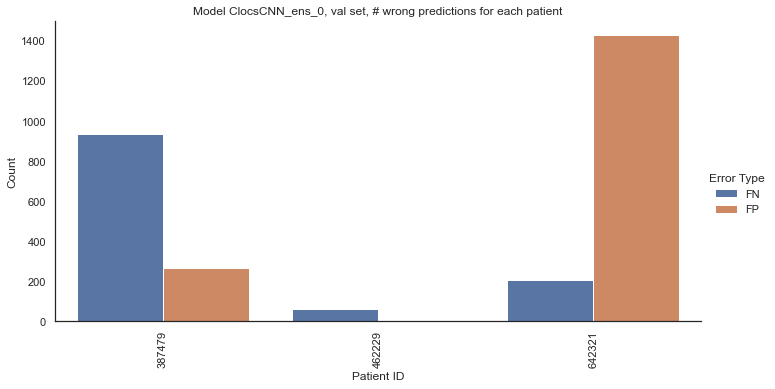

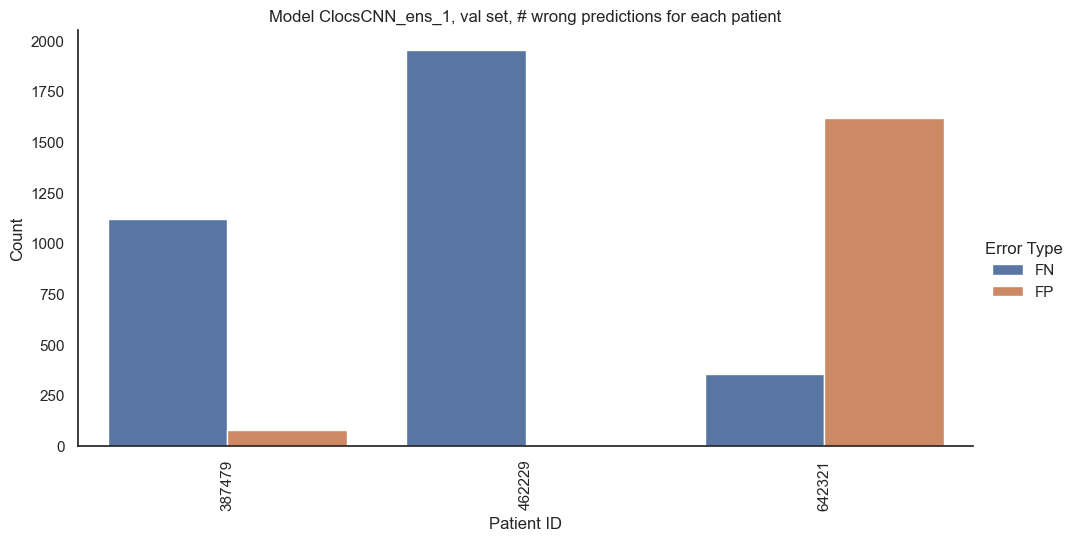

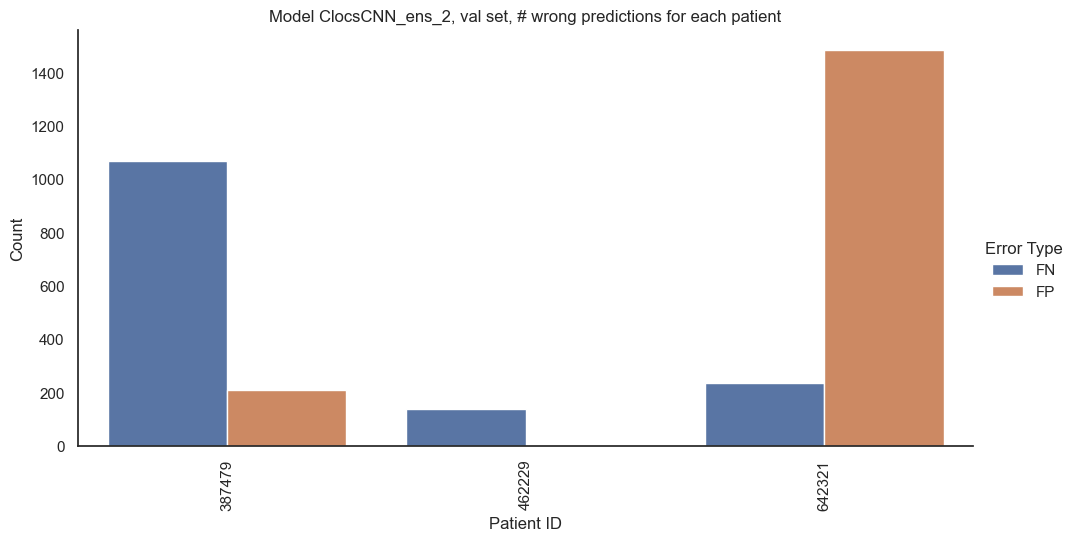

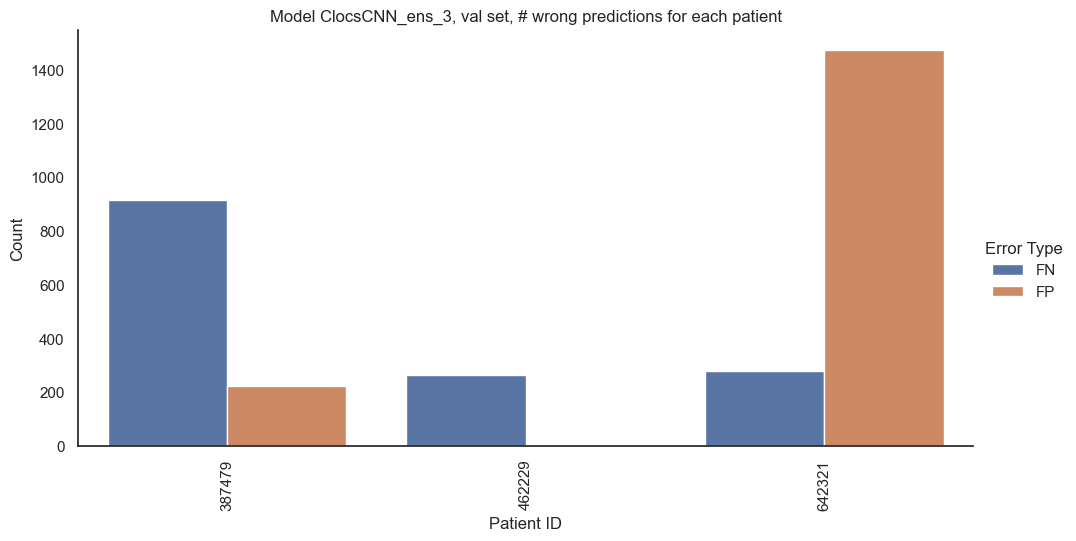

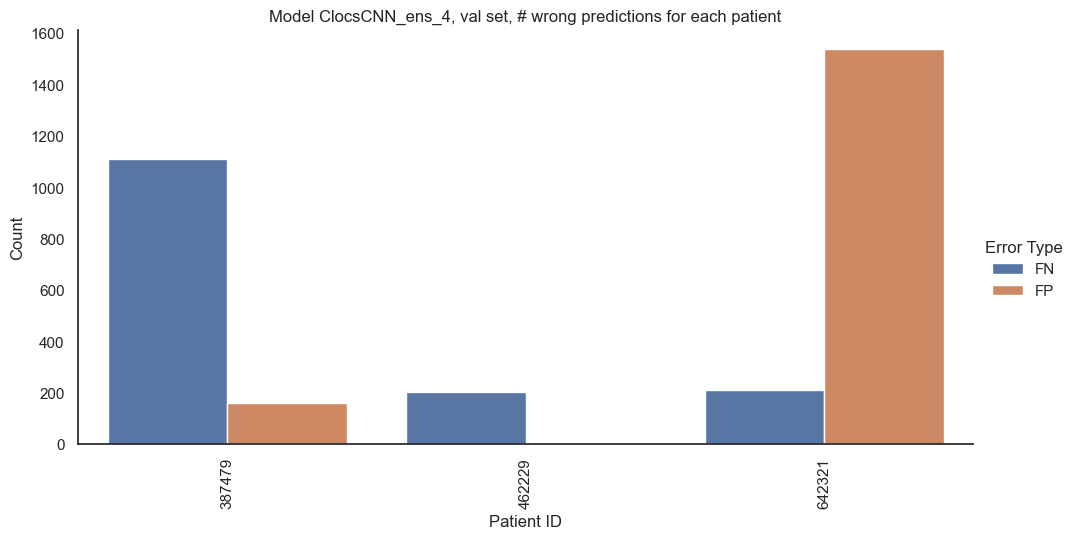

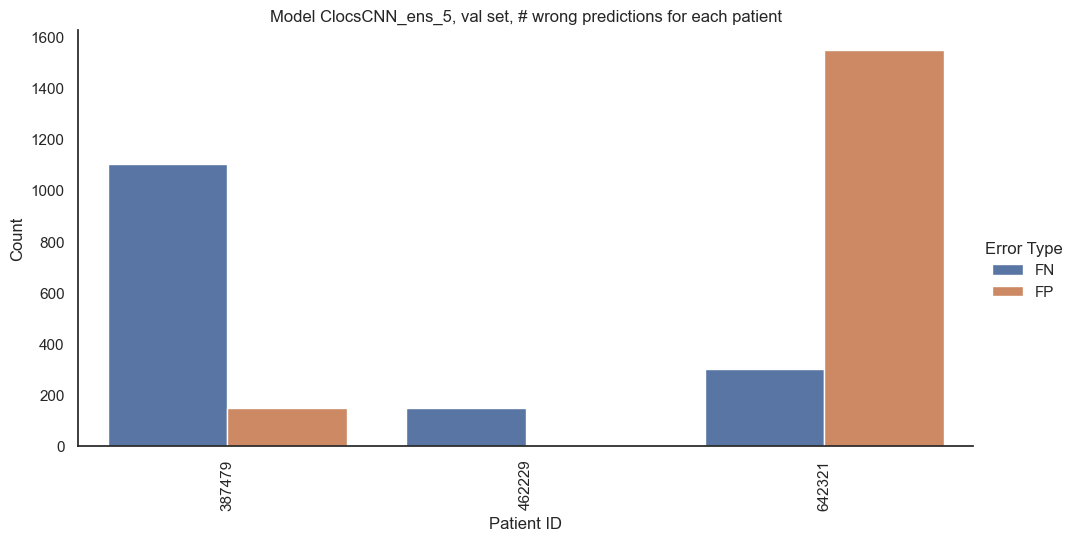

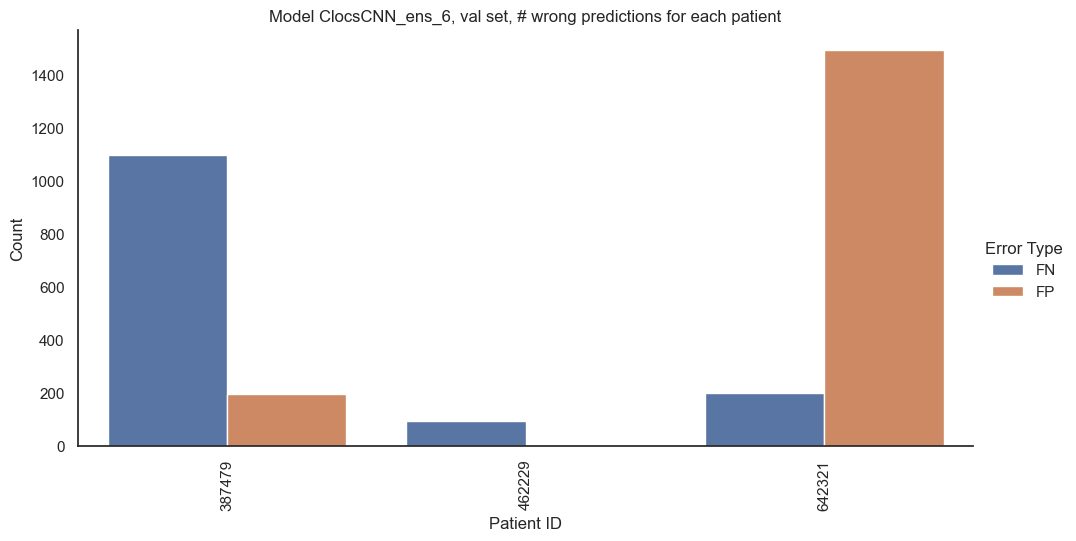

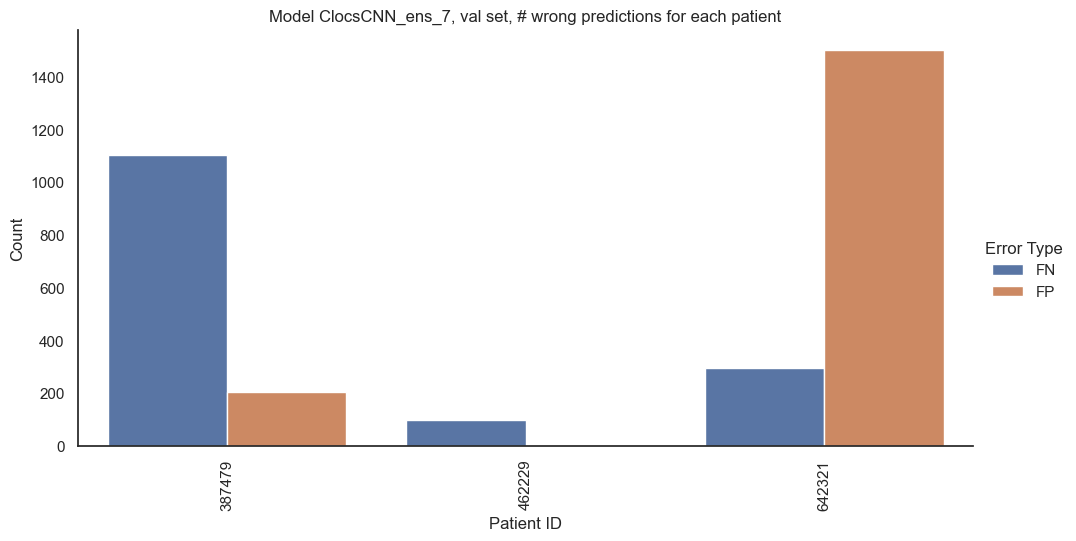

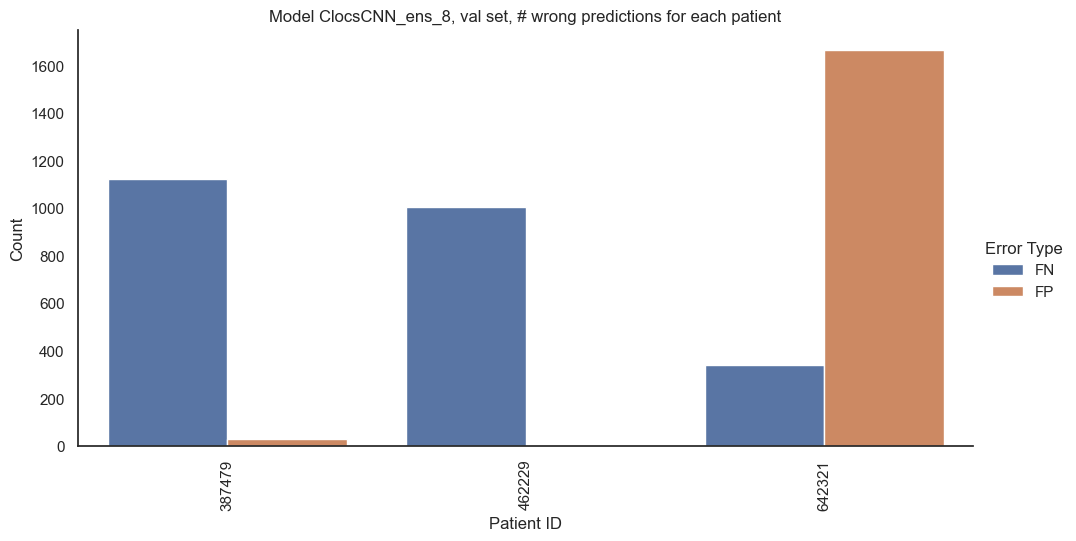

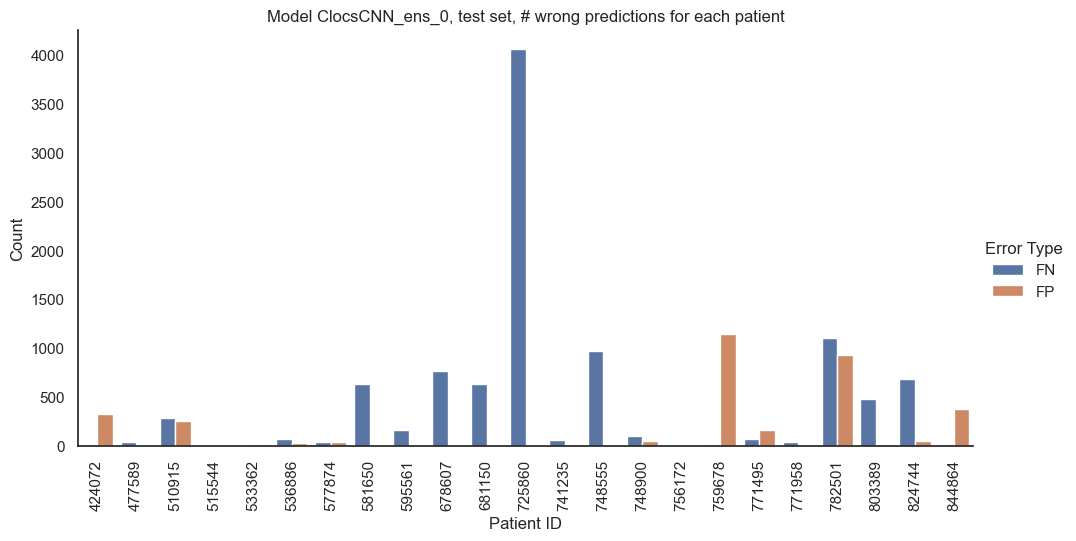

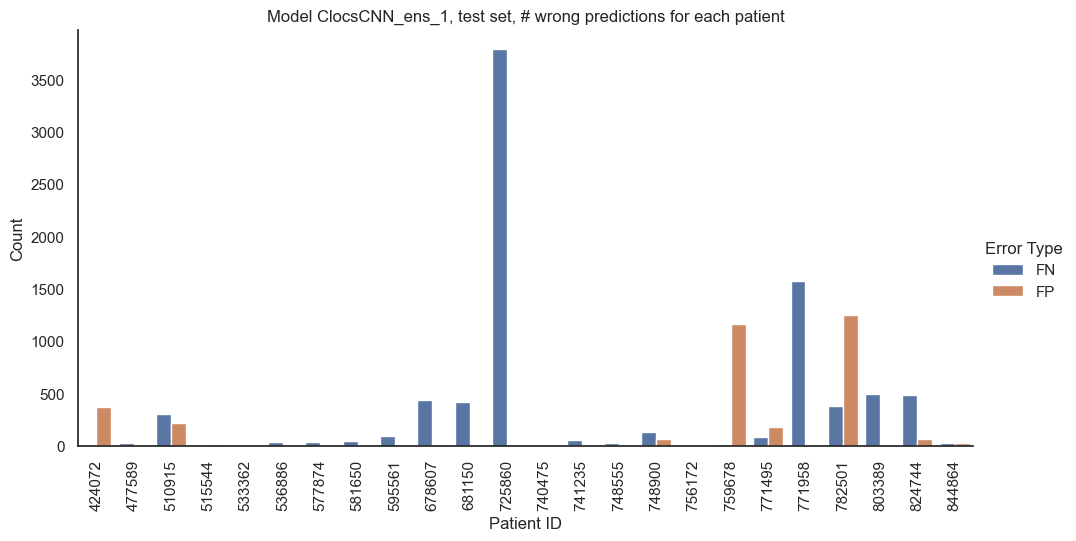

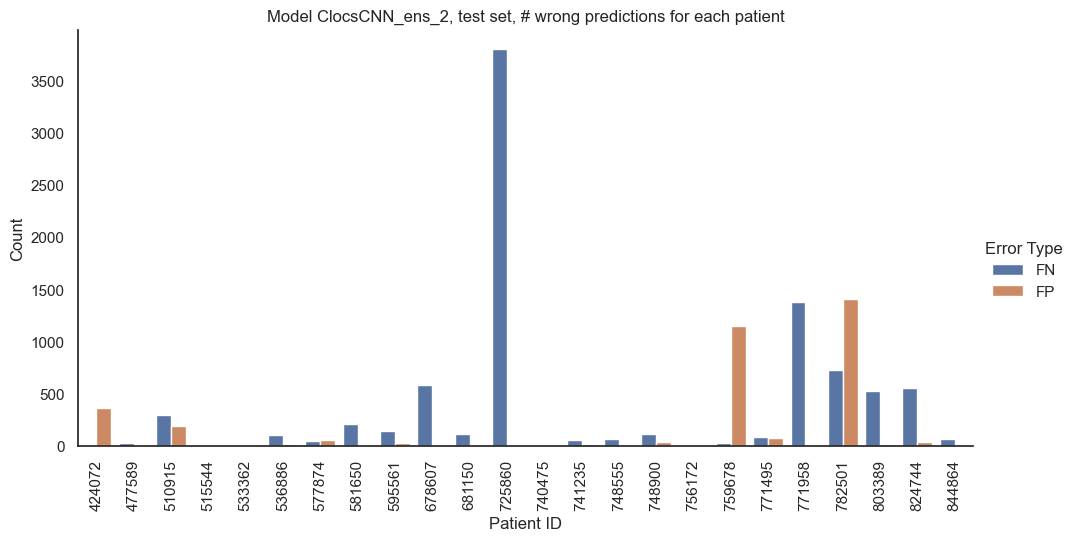

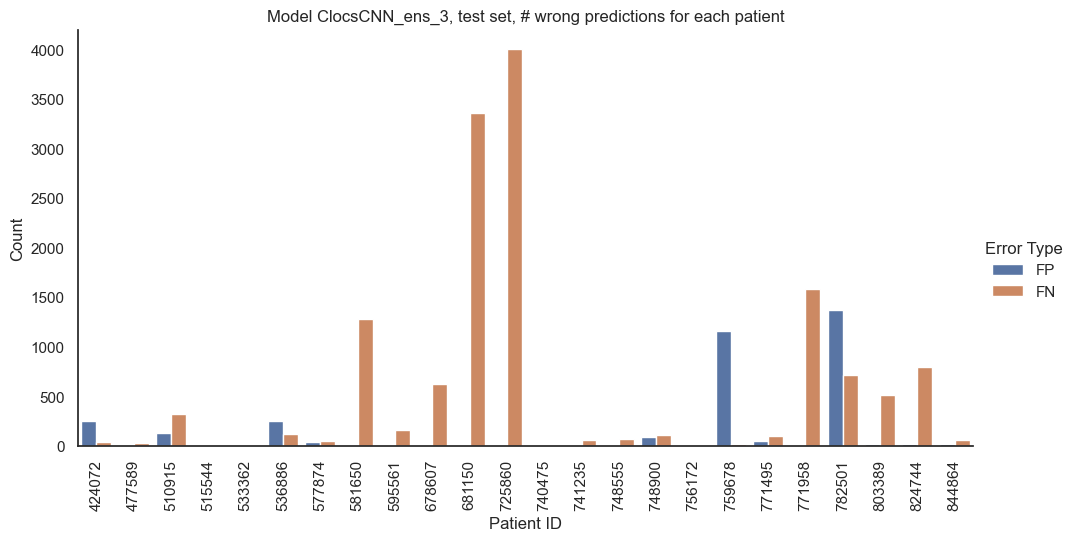

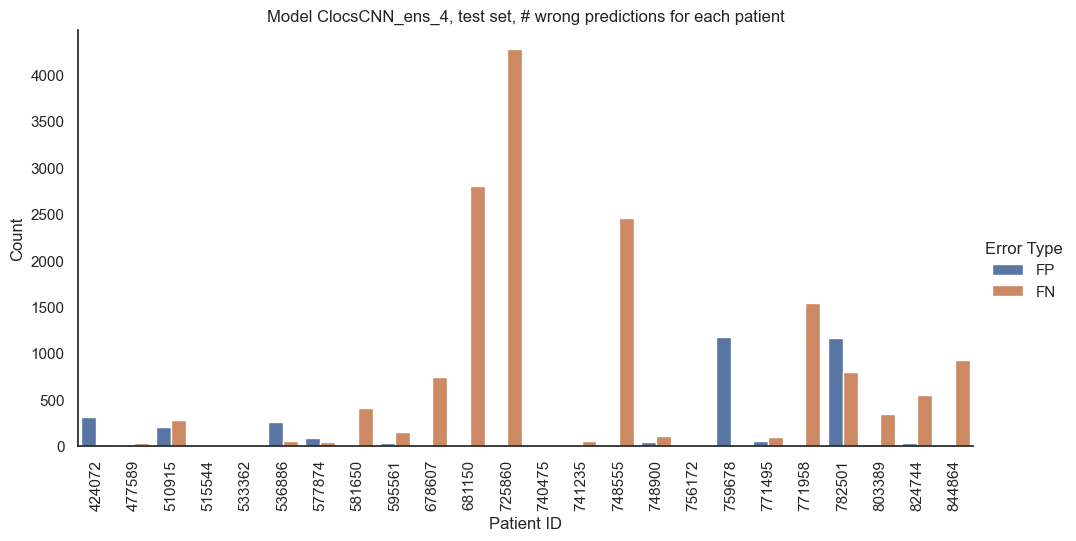

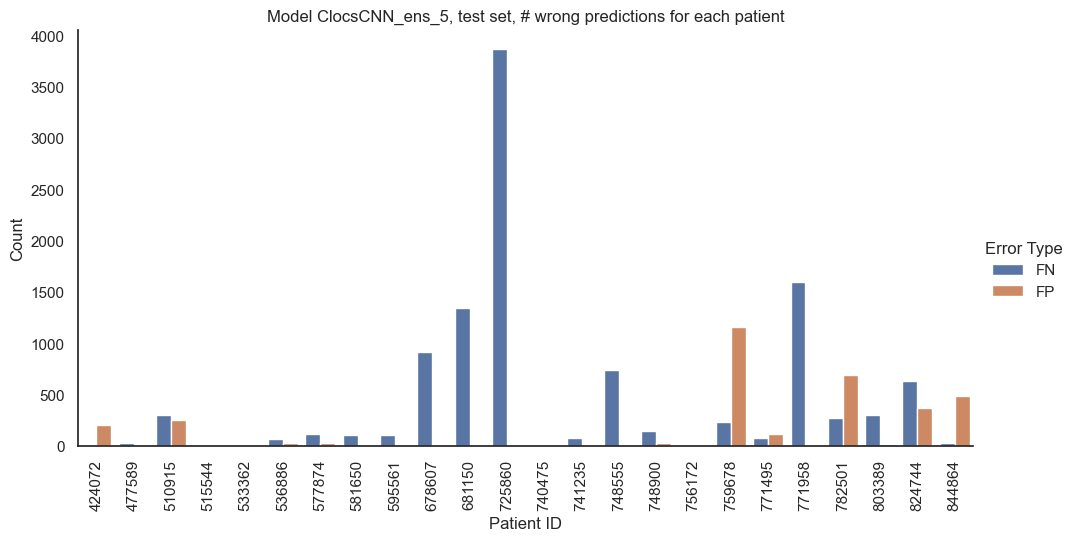

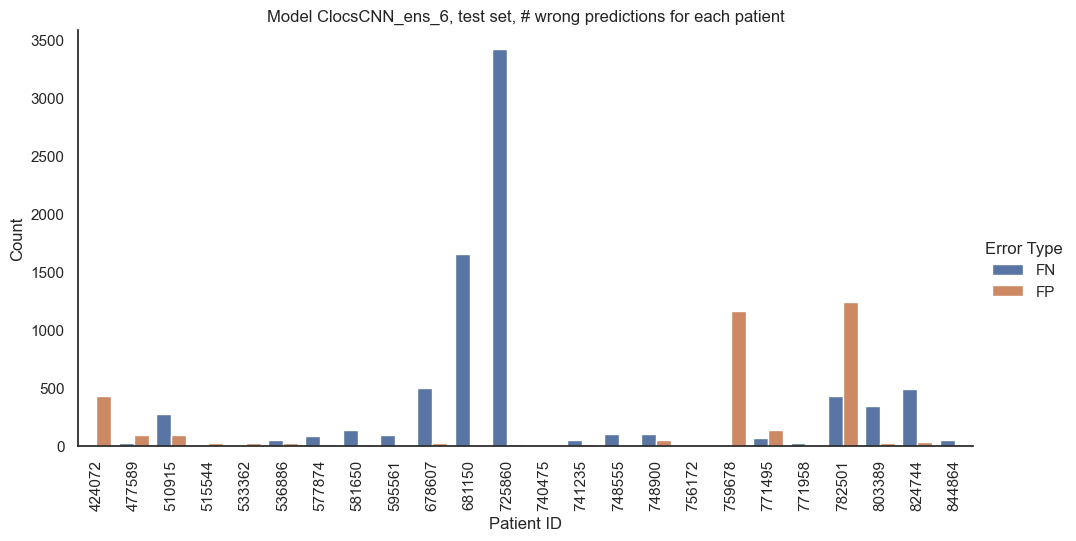

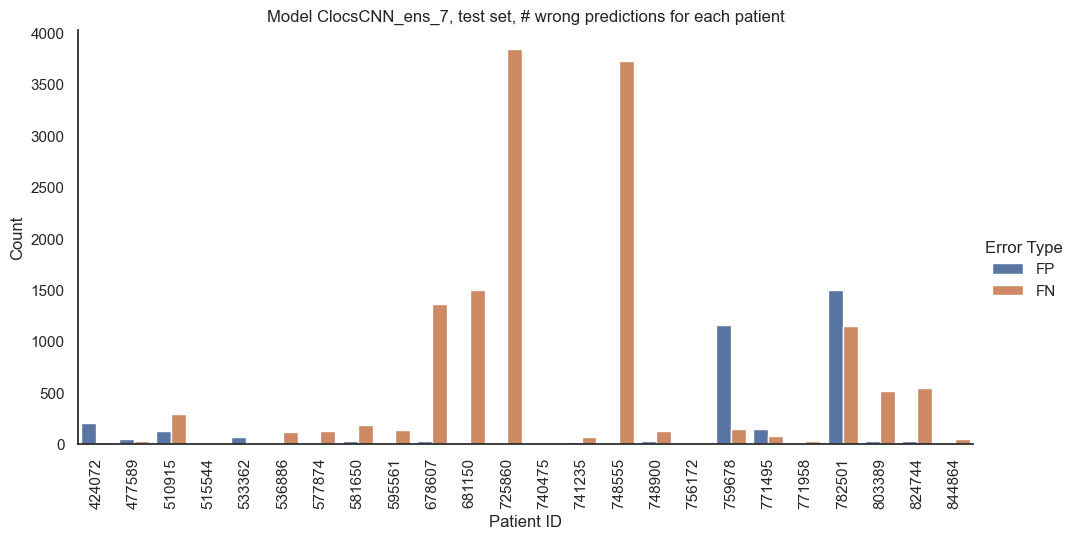

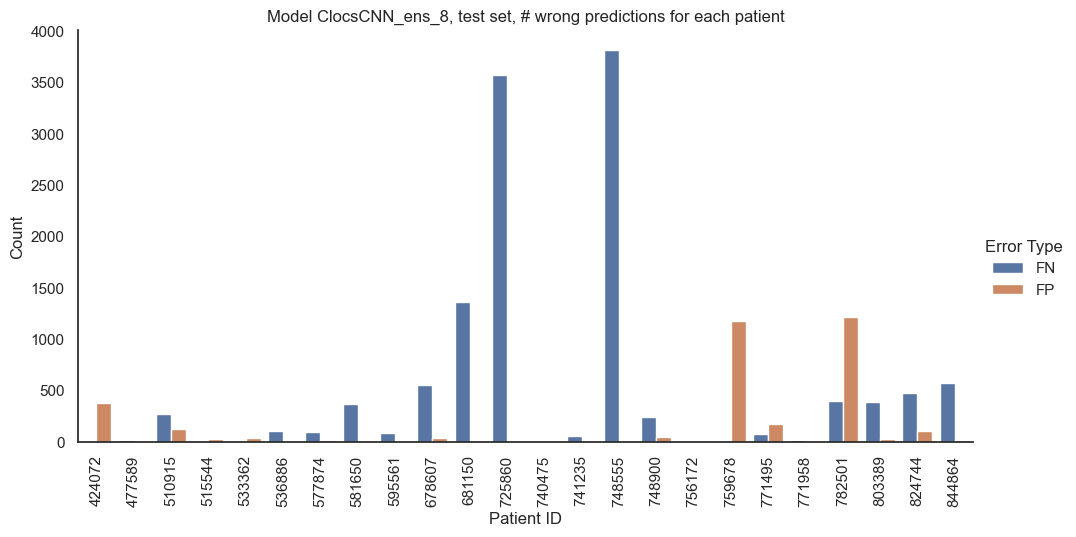

In [16]:
for mode in roc_curve_results_dict_dict_dict:
    error_df_summary_dict_dict[mode] = {}
    error_idx_by_patient_by_type_dict_dict[mode] = {}
    for model_name in roc_curve_results_dict_dict_dict[mode]:
        # idx_list = wrong_indices_dict_train[0] + wrong_indices_dict_train[1]
#         idx_list = wrong_indices_dict_val[0] + wrong_indices_dict_val[1]
        # idx_list = wrong_indices_dict_test[0] + wrong_indices_dict_test[1]
        wrong_indices_dict = wrong_predictions_indices_dict_dict[mode][model_name]
        idx_list = wrong_indices_dict[0] + wrong_indices_dict[1]

        dataset_plot = dataset_dict[mode]
        dataset_id_dict = dataset_id_dict_dict[mode]

        short_identifier_list = dataset_plot.short_identifier_list
        error_df_dict = dict.fromkeys(short_identifier_list)
        for k in error_df_dict:
            error_df_dict[k] = []

        error_idx_by_patient_by_type = {0: {}, 1: {}}
        for i, idx in enumerate(idx_list):
            ecg_signal, _, label = dataset_plot[idx]
            id_dict = Lookup_ECG(ecg_signal, dataset_id_dict)
            for k, v in id_dict.items():
                error_df_dict[k].append(v)
            if id_dict["patient_ID"] in error_idx_by_patient_by_type[label]:
                error_idx_by_patient_by_type[label][id_dict["patient_ID"]].append(idx)
            else:
                error_idx_by_patient_by_type[label][id_dict["patient_ID"]] = [idx]

        error_idx_by_patient_by_type_dict_dict[mode][model_name] = error_idx_by_patient_by_type
        error_df = pd.DataFrame.from_dict(error_df_dict)
        error_df_summary = error_df.groupby(["patient_ID", "label"]).agg({"r_ID_abs": "count"}).reset_index()
        error_df_summary = error_df_summary.rename(columns={"patient_ID": "Patient ID", "r_ID_abs": "Count", "label": "Label"})
        error_df_summary["Error Type"] = "FP"
        error_df_summary.loc[error_df_summary["Label"] == 1, "Error Type"] = "FN"
        error_df_summary = error_df_summary.sort_values(by=["Count"], ascending=False)
        error_df_summary_dict_dict[mode][model_name] = error_df_summary
        print(f"[Error Summary Completed] {mode}, Model {model_name}")
        
        sns.set(style="white")
        g = sns.catplot(data=error_df_summary.sort_values(by=["Patient ID"]), x="Patient ID", y="Count", hue="Error Type", kind="bar", height=5, aspect=2)
        for i, ax_row in enumerate(g.axes):
            for j, ax in enumerate(ax_row):
                for tick in ax.get_xticklabels():
                    tick.set_rotation(90)
                ax.set_title(f"Model {model_name}, {mode} set, # wrong predictions for each patient")